# Finding the catenary curve

Find the catenary, which is the curve $y(x)$ described by a cable hanging from two fixed points. This can be done my minimizing its energy:
$$
E[y] = \int_a^b dx y(x) \sqrt{1 + y'(x)^2}
$$
while holding its length
$$
L[y] = \int_a^b dx \sqrt{1 + y'(x)^2}
$$
and the heights of the extremes $y(a)$ and $y(b)$ fixed.

In [1]:
import elvet

## Computation

We use the functional-minimizer function `minimizer` and the integration module. The available integration methods are

In [2]:
elvet.math.integration_methods

['leftriemann', 'rightriemann', 'trapezoidal', 'simpson', 'boole', 'romberg']

In [18]:
distance = 3
heights = 1, 0
length = 5

def loss(x, y, dy_dx):
    dy_dx = dy_dx[:, 0]
    
    energy = elvet.math.integral(y * (1 + dy_dx**2)**0.5, x)
    current_length = elvet.math.integral((1 + dy_dx**2)**0.5, x)
    bcs = (y[0] - heights[0], y[-1] - heights[1])
 
    return (
        energy
        + 1e3 * (current_length - length)**2
        + 1e2 * sum(bc**2 for bc in bcs)
    )

domain = elvet.box((0, 3, 100))
result = elvet.minimizer(loss, domain, epochs=50000)

 Elvet: epoch = 1, loss = 4.03e+03, elapsed time = 00:00:00
 Elvet: epoch = 10000, loss = -2.34e+00, elapsed time = 00:00:04
 Elvet: epoch = 20000, loss = -2.60e+00, elapsed time = 00:00:07
 Elvet: epoch = 30000, loss = -2.62e+00, elapsed time = 00:00:11
 Elvet: epoch = 40000, loss = -2.62e+00, elapsed time = 00:00:15
 Elvet: epoch = 50000, loss = -2.62e+00, elapsed time = 00:00:19


## Checks

Compare the result with the analytical solution given by
$$
    y(x) = y_0 + a \cosh\frac{x - x_0}{a}
$$
where
$$
   \frac{\sinh A}{a} = \frac{\sqrt{(b - a)^2 - h^2}}{b - a}, \quad
   a = \frac{b - a}{2 A}, \quad
   x_0 = \frac{b - a}{2} - a \; {\rm arctanh} \, \frac{h}{L}, \quad
   y_0 = \frac{y(b) + y(a)}{2} + \frac{b -a}{2 \tanh A}.
$$

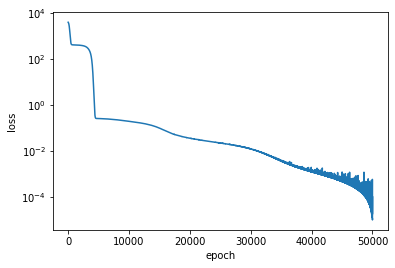

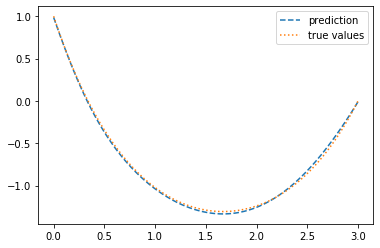

In [15]:
import numpy as np
from scipy.optimize import fsolve

import elvet.plotting

h = heights[1] - heights[0]
r = (length**2 - h**2)**0.5 / distance
A = fsolve(lambda A: r - np.sinh(A) / A, 1)

a = distance / (2 * A)
x_0 = distance / 2 - a * np.arctanh(h / length)
y_0 = (heights[1] + heights[0]) / 2 - length / (2 * np.tanh(A))

x = domain.numpy()
true_function = a * np.cosh((x - x_0) / a) + y_0

min_loss = min(result.losses)
result.losses = [loss - min_loss + 1e-5 for loss in result.losses]
elvet.plotting.plot_losses(result)
elvet.plotting.plot_prediction(result, true_function=true_function)

Check that the length is 5

In [22]:
y, dy_dx = result.derivatives()
elvet.math.integral((1 + dy_dx[:, 0]**2)**0.5, x).numpy().item()

5.000926494598389